In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("proj1b.ipynb")

# Project 1B: Predicting Housing Prices in Cook County

## Due Date: Monday, July 25th, 11:59 PM

### Collaboration Policy

Data science is a collaborative activity. While you may talk with others about the project, we ask that you **write your solutions individually**. If you do discuss the assignments with others please **include their names** in the collaborators cell below.

**Collaborators:** *list names here*

## Introduction

In part A of this project, you performed some basic exploratory data analysis (EDA), laying out the thought process that leads to certain modeling decisions. Then, you added a few new features to the dataset, cleaning the data as well in the process.

In this project, you will specify and fit a linear model to a few features of the housing data to predict housing prices. Next, we will analyze the error of the model and brainstorm ways to improve the model's performance. Finally, we'll delve deeper into the implications of predictive modeling within the Cook County Assessor's Office (CCAO) case study, especially because statistical modeling is how the CCAO valuates properties. Given the history of racial discrimination in housing policy and property taxation in Cook County, consider the impacts of your modeling results as you work through this assignment - and think about what fairness might mean to property owners in Cook County.

After this part of the project, you should be comfortable with:
- Implementing a data processing pipeline using `pandas`
- Using `scikit-learn` to build and fit linear models

## Score Breakdown

Question | Points
----|----
0 | 5
1 | 2
2 | 2
3 | 3
4 | 2
5 | 2
6 | 1
7 | 4
8 | 6
9 | 2
10 | 1
11 | 2
Total | 32

In [2]:
import numpy as np

import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import run_linear_regression_test

# Plot settings
plt.rcParams['figure.figsize'] = (12, 9)
plt.rcParams['font.size'] = 12

Let's load the training and test data.

In [3]:
with zipfile.ZipFile('cook_county_data.zip') as item:
    item.extractall()

In [4]:
training_data = pd.read_csv("cook_county_train.csv", index_col='Unnamed: 0')
test_data = pd.read_csv("cook_county_test.csv", index_col='Unnamed: 0')

As a good sanity check, we should at least verify that the data shape matches the description.

In [5]:
# 204792 observations and 62 features in training data
assert training_data.shape == (204792, 62)
# 68264 observations and 61 features in test data
assert test_data.shape == (68264, 61)
# Sale Price is provided in the training data
assert 'Sale Price' in training_data.columns.values
# Sale Price is hidden in the test data
assert 'Sale Price' not in test_data.columns.values

Let's remind ourselves of the data available to us in the Cook County dataset. Remember, a more detailed description of each variable is included in `codebook.txt`, which is in the same directory as this notebook). **If you did not attempt Project 1A,** you should take some time to familiarize yourself with the codebook before moving forward.

In [6]:
training_data.columns.values

array(['PIN', 'Property Class', 'Neighborhood Code', 'Land Square Feet',
       'Town Code', 'Apartments', 'Wall Material', 'Roof Material',
       'Basement', 'Basement Finish', 'Central Heating', 'Other Heating',
       'Central Air', 'Fireplaces', 'Attic Type', 'Attic Finish',
       'Design Plan', 'Cathedral Ceiling', 'Construction Quality',
       'Site Desirability', 'Garage 1 Size', 'Garage 1 Material',
       'Garage 1 Attachment', 'Garage 1 Area', 'Garage 2 Size',
       'Garage 2 Material', 'Garage 2 Attachment', 'Garage 2 Area',
       'Porch', 'Other Improvements', 'Building Square Feet',
       'Repair Condition', 'Multi Code', 'Number of Commercial Units',
       'Estimate (Land)', 'Estimate (Building)', 'Deed No.', 'Sale Price',
       'Longitude', 'Latitude', 'Census Tract',
       'Multi Property Indicator', 'Modeling Group', 'Age', 'Use',
       "O'Hare Noise", 'Floodplain', 'Road Proximity', 'Sale Year',
       'Sale Quarter', 'Sale Half-Year', 'Sale Quarter of Year'

<!-- BEGIN QUESTION -->

## Question 0
### Question 0a
"How much is a house worth?" Who might be interested in an answer to this question? Please list at least three different parties (people or organizations) and state whether each one has an interest in seeing the value be high or low.

<!--
BEGIN QUESTION
name: q0a
points: 1
manual: True
-->

The parties who might be interested in house values include real estate agency, house buyers, and property tax department in the government. Real estate agency and property tax department have an intertest in high values because they might earn more. House buyers has an interest in low values because it means to cost less. 

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 0b

Which of the following scenarios strike you as unfair and why? You can choose more than one. There is no single right answer but you must explain your reasoning.

A. A homeowner whose home is assessed at a higher price than it would sell for.  
B. A homeowner whose home is assessed at a lower price than it would sell for.  
C. An assessment process that systematically overvalues inexpensive properties and undervalues expensive properties.  
D. An assessment process that systematically undervalues inexpensive properties and overvalues expensive properties.


<!--
BEGIN QUESTION
name: q0b
points: 1
manual: True
-->

The third(C) scenario strikes me as unfair. This unfair assessment system creates a visible divide along social class. Wealthy homeowners, paid less in property taxes, whereas working-class, homeowners having inexpensive properties have to paid more tax.

<!-- END QUESTION -->

### Question 0c

Consider a model that is fit to $n = 30$ training observations. Call the response $y$ (Log Sale Price), the predictions $\hat{y}$, and the residuals $y - \hat{y}$. Which of the following residual plots of $y$ versus $y - \hat{y}$ correspond to a model that might make property assessments that result in to regressive taxation?

![](res-plots.png)res-plots.png

<!--
BEGIN QUESTION
name: q0c
points: 1
-->

In [7]:
q0c = "B"

In [8]:
grader.check("q0c")

q0c results: All test cases passed!

## The CCAO Dataset

The dataset you’ll be working with comes from the Cook County Assessor’s Office (CCAO) in Illinois, a government institution that determines property taxes across most of Chicago’s metropolitan area and its nearby suburbs. In the United States, all property owners are required to pay property taxes, which are then used to fund public services including education, road maintenance, and sanitation. These property tax assessments are based on property values estimated using statistical models that consider multiple factors, such as real estate value and construction cost.

This system, however, is not without flaws. In late 2017, a lawsuit was filed against the office of Cook County Assessor Joseph Berrios for producing “[racially discriminatory assessments and taxes](https://www.chicagotribune.com/politics/ct-cook-county-board-assessor-berrios-met-20170718-story.html)." The lawsuit included claims that the assessor’s office undervalued high-priced homes and overvalued low-priced homes, creating a visible divide along racial lines: Wealthy homeowners, who were typically white, [paid less in property taxes](https://www.clccrul.org/bpnc-v-berrios-facts?rq=berrios), whereas [working-class, non-white homeowners paid more](https://www.chicagotribune.com/news/breaking/ct-cook-county-assessor-berrios-sued-met-20171214-story.html).

The Chicago Tribune's four-part series, "[The Tax Divide](https://www.chicagotribune.com/investigations/ct-tax-divide-investigation-20180425-storygallery.html)", delves into how this was uncovered: After "compiling and analyzing more than 100 million property tax records from the years 2003 through 2015, along with thousands of pages of documents, then vetting the findings with top experts in the field," they discovered that "residential assessments had been so far off the mark for so many years." You can read more about their investigation [here](https://apps.chicagotribune.com/news/watchdog/cook-county-property-tax-divide/assessments.html).

And make sure to watch [Lecture 14](https://ds100.org/sp22/lecture/lec14/) before answering the following questions!

<!-- BEGIN QUESTION -->

### Question 0d

What were the central problems with the earlier property tax system in Cook County as reported by the Chicago Tribune ? And what were the primary causes of these problems? (Note: in addition to reading the paragraph above you will need to watch the lecture to answer this question)
<!--
BEGIN QUESTION
name: q0d
points: 1
manual: True
-->

The central problems are that Cook country failed to value homes accurately and a property tax system harmed the poor and helped the wealth. Specifically, as income level rises, effective taxt rates decline. The primary cause is regessive tax, segregation and credit-market racism.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

### Question 0e

In addition to being regressive, why did the property tax system in Cook County place a disproportionate tax burden on non-white property owners?
<!--
BEGIN QUESTION
name: q0e
points: 1
manual: True
-->

It arises from structural racism and part of a deeper, institutional pattern, potential corruption.

<!-- END QUESTION -->

## Question 1

Now, let's split the data set into a training set and test set. We will use the training set to fit our model's parameters, and we will use the test set to estimate how well our model will perform on unseen data drawn from the same distribution. If we used all the data to fit our model, we would not have a way to estimate model performance on **unseen data**.

"Don't we already have a test set in `cook_county_test.csv`?" you might wonder. The sale prices for `cook_county_test.csv` aren't provided, so we're constructing our own test set for which we know the outputs.

In the cell below, complete the function `train_test_split` that splits `data` into two smaller DataFrames named `train` and `test`. Let `train` contain 80% of the data, and let `test` contain the remaining 20% of the data. 

To do this, first create two NumPy arrays named `train_indices` and `test_indices`. `train_indices` should contain a *random* 80% of the indices in `full_data`, and `test_indices` should contain the remaining 20% of the indices. Then, use these arrays to index into `full_data` to create your final `train` and `test` DataFrames.

*The provided tests check that you not only answered correctly, but ended up with the exact same train/test split as our reference implementation. Later testing is easier this way.*

**Note**: You should not be importing any additional libraries for this question. 

<!--
BEGIN QUESTION
name: q1
points: 2
-->

In [29]:
# This makes the train-test split in this section reproducible across different runs 
# of the notebook. You do not need this line to run train_test_split in general

# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

def train_test_split(data):
    data_len = data.shape[0]
    shuffled_indices = np.random.permutation(data_len)
    
    pivot = int(data_len*0.8)
    train_index = shuffled_indices[:pivot]
    test_index = shuffled_indices[pivot:]
    
    train_set = data.iloc[train_index]
    test_set = data.iloc[test_index]
    return train_set,test_set
train, test = train_test_split(training_data)

In [30]:
grader.check("q1")

q1 results: All test cases passed!

Now, let's fit our updated linear regression model using the ordinary least squares estimator! We will start you off with something simple by using only 2 features: the **number of bedrooms** in the household and the **log-transformed total area covered by the building** (in square feet). 

Consider the following expression for our 1st linear model that contains one of the features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

In parallel, we will also consider a 2nd model that contains both features:

$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

<!-- BEGIN QUESTION -->

## Question 2

**Without running any calculation or code**, complete the following statement by filling in the blank with one of the  comparators below:

$$\ge$$
$$\le$$
$$=$$

Suppose we quantify the loss on our linear models using MSE (Mean Squared Error). Consider the training loss of the 1st model and the training loss of the 2nd model. We are guaranteed that:

$$
\text{Training Loss of the 1st Model}  \_\_\_\_\_  \text{Training Loss of the 2nd Model}
$$

<!--
BEGIN QUESTION
name: q2
points: 2
manual: True
-->

$$\ge$$

<!-- END QUESTION -->



## Question 3

In part A, you wrote a few functions that added features to the dataset. Instead of manually calling each function to add these features to the dataset, it is best practice to encapsulate all of this feature engineering into one "pipeline" function. Defining and using a pipeline reduces all the feature engineering to just one function call and ensures that the same transformations are applied to all data. In this question, we will build a pipeline with the function `process_data_gm`. 

Take a look at the following function `process_data_gm`, which takes in a dataframe `data`, a list `pipeline_functions` containing 3-element tuples `(function, arguments, keyword_arguments)` that will be called on `data` in the pipeline, and the label `prediction_col` that represents the column of our target variable (`Sale Price` in this case). It returns two NumPy arrays: `X`, which is our design matrix, and `y` which is the vector containing the observed data. Take a look at our use of [pd.DataFrame.pipe](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.pipe.html); you can use this function with each of the tuples passed in through `pipeline_functions`.

In [31]:
from feature_func import *    # imports functions from Project 1A
# run this cell to define process_data_gm and select_columns

def process_data_gm(data, pipeline_functions, prediction_col):
    """Process the data for a guided model."""
    for function, arguments, keyword_arguments in pipeline_functions:
        if keyword_arguments and (not arguments):
            data = data.pipe(function, **keyword_arguments)
        elif (not keyword_arguments) and (arguments):
            data = data.pipe(function, *arguments)
        else:
            data = data.pipe(function)
    X = data.drop(columns=[prediction_col]).to_numpy()
    y = data.loc[:, prediction_col].to_numpy()
    return X, y

In [32]:
def select_columns(data, *columns):
    """Select only columns passed as arguments."""
    return data.loc[:, columns]

def log_transform(data, col):
    """Add the log transformation of a column to the data frame"""
    data['Log ' + col] = np.log(data[col])
    return data

It is time to prepare the training and validation data for the two models we proposed above. Use the following 2 cells to reload a fresh dataset from scratch and run them through the following preprocessing steps for each model:

- Perform a `train_test_split` on the original dataset. Let 80% of the set be training data and 20% of the set be validation data. **Even though we are splitting our dataset into training and validation sets, this question will refer to the validation set as the test set.**
- For both the training and validation set,
    1. Remove outliers in `Sale Price` by so that we are considering households with a price that is strictly greater than 499 dollars (i.e., greater than or equal to 500 dollars). 
    2. Apply log transformations to `Sale Price` and the `Building Square Feet` columns to create 2 new columns `Log Sale Price` and `Log Building Square Feet`.
    3. Extract the total number of bedrooms into a new column `Bedrooms` from the `Description` column.
    4. Select the columns `Log Sale Price` and `Bedrooms` (and `Log Building Square Feet` as well if this is the 2nd model).
    5. Return the design matrix $X$ and the observed vector $y$. **Your design matrix and observed vector should either be numpy arrays or pandas dataframes**.
    

Assign the final training data and validation data for both models to the following set of variables:

- 1st Model: `X_train_m1`, `y_train_m1`, `X_test_m1`, `y_test_m1`
- 2nd Model: `X_train_m2`, `y_train_m2`, `X_test_m2`, `y_test_m2`

**We have automatically imported staff implementations of the functions you wrote in Project 1A.** These functions are `remove_outliers`, `add_total_bedrooms`, `find_expensive_neighborhoods`, `add_in_expensive_neighborhood`, and `ohe_roof_material`. You are welcome to copy over your own implementations if you like.

**Hint:** We have processed the data for the first model for you below to use as an example.

**Note**: Do not change the line `np.random.seed(1337)` as it ensures we are partitioning the dataset exactly the same way for both models (otherwise their performance isn't directly comparable).

In [33]:
# Reload the data
full_data = pd.read_csv("cook_county_train.csv")

# Process the data using the pipeline for the first model
np.random.seed(1337)
train_m1, test_m1 = train_test_split(full_data)

m1_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms'], None)
]


X_train_m1, y_train_m1 = process_data_gm(train_m1, m1_pipelines, 'Log Sale Price')
X_test_m1, y_test_m1 = process_data_gm(test_m1, m1_pipelines, 'Log Sale Price')

In [34]:
# DO NOT CHANGE THIS LINE
np.random.seed(1337)
# DO NOT CHANGE THIS LINE

# Process the data using the pipeline for the second model
train_m2, test_m2 = train_test_split(full_data)

m2_pipelines = [
    (remove_outliers, None, {
        'variable': 'Sale Price',
        'lower': 499,
    }),
    (log_transform, None, {'col': 'Sale Price'}),
    (log_transform, None, {'col': 'Building Square Feet'}),
    (add_total_bedrooms, None, None),
    (select_columns, ['Log Sale Price', 'Bedrooms','Log Building Square Feet'], None)
]
X_train_m2, y_train_m2 = process_data_gm(train_m2, m2_pipelines, 'Log Sale Price')
X_test_m2, y_test_m2 = process_data_gm(test_m2, m2_pipelines, 'Log Sale Price')


In [35]:
grader.check("q3")

q3 results: All test cases passed!

## Question 4

Finally, let's do some regression!

We first initialize a [`sklearn.linear_model.LinearRegression`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html) object for both of our models. We set the `fit_intercept = True` to ensure that the linear model has a non-zero intercept (i.e., a bias term).

In [36]:
linear_model_m1 = lm.LinearRegression(fit_intercept=True)
linear_model_m2 = lm.LinearRegression(fit_intercept=True)

Now it's time to fit our linear regression model. Use the cell below to fit both models, and then use it to compute the fitted values of `Log Sale Price` over the training data, and the predicted values of `Log Sale Price` for the testing data.

Assign the predicted values from both of your models on the training and testing set to the following variables:

- 1st Model: prediction on training set: `y_fitted_m1`, prediction on testing set: `y_predicted_m1`
- 2nd Model: prediction on training set: `y_fitted_m2`, prediction on testing set: `y_predicted_m2`

**Note**: To make sure you understand how to find the predicted value for both the training and testing data set, there won't be any hidden tests for this part.
<!--
BEGIN QUESTION
name: q4
points: 2
-->

In [37]:
# Fit the 1st model
# Compute the fitted and predicted values of Log Sale Price for 1st model
linear_model_m1.fit(X_train_m1, y_train_m1)
y_fitted_m1 = linear_model_m1.predict(X_train_m1)
y_predicted_m1 = linear_model_m1.predict(X_test_m1)

# Fit the 2nd model
# Compute the fitted and predicted values of Log Sale Price for 2nd model
linear_model_m2.fit(X_train_m2, y_train_m2)
y_fitted_m2 = linear_model_m2.predict(X_train_m2)
y_predicted_m2 = linear_model_m2.predict(X_test_m2)

In [38]:
grader.check("q4")

q4 results: All test cases passed!

## Question 5

We are moving into analysis of our two models! Let's compare the performance of our two regression models using the Root Mean Squared Error function.

$$RMSE = \sqrt{\dfrac{\sum_{\text{houses in test set}}(\text{actual price for house} - \text{predicted price for house})^2}{\text{number of of houses}}}$$

The function is provided below.

In [39]:
def rmse(predicted, actual):
    """
    Calculates RMSE from actual and predicted values
    Input:
      predicted (1D array): vector of predicted/fitted values
      actual (1D array): vector of actual values
    Output:
      a float, the root-mean square error
    """
    return np.sqrt(np.mean((actual - predicted)**2))

Now use your `rmse` function to calculate the training error and test error for both models in the cell below.

Assign the error from both of your models to the following variables:

- 1st model: `training_error_m1`, `test_error_m1`
- 2nd model: `training_error_m2`, `test_error_m2`

Since the target variable we are working with is log-transformed, it can also be beneficial to transform it back to its original form so we will have more context on how our model is performing when compared to actual housing prices.

Assign the error on the "de-log-transformed" sale price from both of your models to the following variables:

- 1st model: `training_error_m1_delog`, `test_error_m1_delog`
- 2nd model: `training_error_m2_delog`, `test_error_m2_delog`

<!--
BEGIN QUESTION
name: q5
points: 2
-->

In [40]:
# Training and test errors for the 1st model
training_error_m1 = rmse(y_train_m1,y_fitted_m1)
test_error_m1 = rmse(y_test_m1,y_predicted_m1)

# Training and test errors for the 1st model (in its original values before the log transform)
training_error_m1_delog = np.exp(training_error_m1)
test_error_m1_delog = np.exp(test_error_m1)


# Training and test errors for the 2nd model
training_error_m2 = rmse(y_train_m2,y_fitted_m2)
test_error_m2 = rmse(y_test_m1,y_predicted_m2)


# Training and test errors for the 2nd model (in its original values before the log transform)
training_error_m2_delog = np.exp(training_error_m2)
test_error_m2_delog = np.exp(test_error_m2)

print("1st Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1, test_error_m1))
print("1st Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m1_delog, test_error_m1_delog))
print("2nd Model\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2, test_error_m2))
print("2nd Model (no log transform)\nTraining RMSE: {}\nTest RMSE: {}\n".format(training_error_m2_delog, test_error_m2_delog))

1st Model
Training RMSE: 0.9025651719699077
Test RMSE: 0.9068644732045896

1st Model (no log transform)
Training RMSE: 2.4659205152646577
Test RMSE: 2.47654507310253

2nd Model
Training RMSE: 0.8042009333446841
Test RMSE: 0.8113963052434995

2nd Model (no log transform)
Training RMSE: 2.2349099431133252
Test RMSE: 2.251048944742962



In [41]:
grader.check("q5")

q5 results: All test cases passed!

<!-- BEGIN QUESTION -->

## Question 6

Let's compare the actual parameters ($\theta_0$ and $\theta_1$) from both of our models. As a quick reminder,

for the 1st model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms})
$$

for the 2nd model,
$$
\text{Log Sale Price} = \theta_0 + \theta_1 \cdot (\text{Bedrooms}) + \theta_2 \cdot (\text{Log Building Square Feet})
$$

Run the following cell and compare the values of $\theta_1$ from both models. Why does $\theta_1$ change from positive to negative when we introduce an additional feature in our 2nd model? 

<!--
BEGIN QUESTION
name: q6
points: 1
manual: True
-->

In [42]:
# Parameters from 1st model
theta0_m1 = linear_model_m1.intercept_
theta1_m1 = linear_model_m1.coef_[0]

# Parameters from 2nd model
theta0_m2 = linear_model_m2.intercept_
theta1_m2, theta2_m2 = linear_model_m2.coef_

print("1st Model\nθ0: {}\nθ1: {}".format(theta0_m1, theta1_m1))
print("2nd Model\nθ0: {}\nθ1: {}\nθ2: {}".format(theta0_m2, theta1_m2, theta2_m2))

1st Model
θ0: 10.571725401040084
θ1: 0.4969197463141442
2nd Model
θ0: 1.9339633173823696
θ1: -0.030647249803554506
θ2: 1.4170991378689644


Because we include a second feature, Log Building Square Feet, in the second model, it is more "important" than Bedrooms, so the importance of Bedrooms decreases. We can explain why theta1 becomes negative by thinking as follows: larger Log Building Square Feet results in higher price, however, when Log Building Square Feet is fixed, larger number of bedrooms results in lower prices.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

## Question 7
### Question 7a

Another way of understanding the performance (and appropriateness) of a model is through a plot of the model the residuals versus the observations.

In the cell below, use [`plt.scatter`](https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.scatter.html) to plot the residuals from predicting `Log Sale Price` using **only the 2nd model** against the original `Log Sale Price` for the **test data**. You should also ensure that the dot size and opacity in the scatter plot are set appropriately to reduce the impact of overplotting.

<!--
BEGIN QUESTION
name: q7a
points: 2
manual: True
format: image
-->

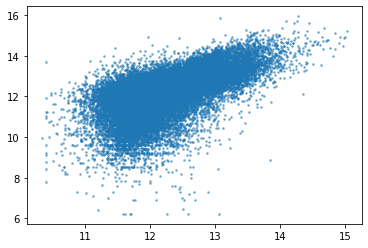

In [43]:
plt.scatter(x = y_predicted_m2, y = y_test_m2, s = 2.5, alpha = 0.5);

<!-- END QUESTION -->

### Question 7b

Based on the structure you see in your plot, does this model seem like it will correspond to _regressive_, _fair_, or _progressive_ taxation?

<!--
BEGIN QUESTION
name: q7b
points: 2
-->

In [44]:
q7b = "fair"

In [45]:
grader.check("q7b")

q7b results: All test cases passed!

While our simple model explains some of the variability in price, there is certainly still a lot of room for improvement to be made -- one reason is we have been only utilizing 1 or 2 features (out of a total of 70+) so far! Can you engineer and incoporate more features to improve the model's fairness and accuracy? We won't be asking you to provide your answers here, but this would be important going into the next part (also last part, wohoo!) of this assignment.

## Question 8

It is time to build your own model!

Just as in the guided model from the previous question, you should encapsulate as much of your workflow into functions as possible. Your job is to select better features and define your own feature engineering pipeline inside the function `process_data_fm` in the following cell. **You must not change the parameters inside `process_data_fm`**.

To evaluate your model, we will start by defining a linear regression model called `final_model`. Then, we will process training data using your `process_data_fm`, fit `final_model` with this training data, and compute the training RMSE. Then, we will process some test data with your `process_data_fm`, use `final_model` to predict `Log Sale Price` for the test data, transform the predicted and original log values back into their original forms (by using `delog`), and compute the test RMSE.

**Notes**: 
- **If you are running into memory issues, restart kernel and only run the cells you need to.** The cell below (question cell) contains most to all of the imports necessary to successfully complete this portion of the project, so it can be completed (almost) independently code-wise from the remainder of the project. The autograder will have more than 2 GB memory, so you will not lose credit as long as your solution to Question 8 is within the total memory limits of DataHub. Alternatively, you can delete variables you are not using through `del` or `%reset -f`. For example, this will free up memory from data used for older models: `del training_data, test_data, train, test, X_train_m1, X_test_m1, X_train_m2, X_test_m1`. Our staff solution (Summer 2022) can be run independently from all other questions, so we encourage you to do the same to make debugging easier.
- `delog` is a function we will run to undo the log transformation on your predictions/original sale prices. Before submitting to Gradescope, make sure that your predicted values can all be delogged (i.e. if the value is 100, it is too large - $e^{100}$ is too big!)
- We will **not** use the test data as provided in `cook_county_test.csv`, but we will assess your model using `cook_county_contest_test.csv`. 
- It is your duty to make sure that all of your feature engineering and selection happens in `process_data_fm`, and that the function performs as expected without errors. We will **NOT** accept regrade requests that require us to go back and run code that require typo/bug fixes.
- You **MUST remove any additional new cells you add below the current one before submitting to Gradescope** to avoid any autograder errors. 
- Do **not** edit the two lines at the end of the question cell below - if you do, you will receive no credit for this question.

**Hints:** 
- Some features may have missing values in the test set but not in the training set. Make sure `process_data_fm` handles missing values appropriately for each feature!
- Pay a *lot* of attention to how you filter your outliers. Treat your upper outlier percentile as a hyperparameter. How can we filter the optimal number of outliers to obtain the best possible test RMSE?


### Grading Scheme

Your grade for Question 8 will be based on your training RMSE and contest **test** RMSE (note that this is another test set, separate from our existing test set!). The thresholds are as follows:

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Training RMSE | Less than 200k | [200k, 240k) | [240k, 280k) | More than 280k

Points | 3 | 2 | 1 | 0
--- | --- | --- | --- | ---
Test RMSE | Less than 240k | [240k, 280k) | [280k, 300k) | More than 300k

<!--
BEGIN QUESTION
name: q8
points: 3
-->

In [90]:
# Define any additional helper functions you need here

# Uncomment the lines below to clean up memory from previous questions and reinitialize Otter!
# MAKE SURE TO COMMENT THE NEXT 3 LINES OUT BEFORE SUBMITTING!
%reset -f
import otter
grader = otter.Notebook("proj1b.ipynb")

import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import linear_model as lm

import warnings
warnings.filterwarnings("ignore")

import zipfile
import os

from ds100_utils import *
from feature_func import *

import scipy
from scipy import stats


# Please include all of your feature engineering process inside this function.
# Do not modify the parameters of this function.
def process_data_fm(data, is_test_set=False):
    # Whenever you access 'Log Sale Price' or 'Sale Price', make sure to use the
    # condition is_test_set like this:
    if not is_test_set:
        # do your processing for the training set (i.e. not the test set)
        # this can involve references to sale price!
        data = remove_outliers(data, variable='Sale Price', lower=np.percentile(data['Sale Price'], 10), upper=np.percentile(data['Sale Price'], 90))
        data = remove_outliers(data, variable='Building Square Feet', lower=np.percentile(data['Building Square Feet'], 5), upper=np.percentile(data['Building Square Feet'], 95))
        data = remove_outliers(data, variable='Age Decade', lower=np.percentile(data['Age Decade'], 5), upper=np.percentile(data['Age Decade'], 95))
       
        data['Log Sale Price'] = np.log(data['Sale Price'])
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
        data['Log Land Square Feet'] = np.log(data['Land Square Feet'])
        data = add_total_bedrooms(data)
        data = select_columns(data,
                        'Log Sale Price',
                        'Log Building Square Feet',
                        'Age Decade',
                        'Bedrooms')
                      
    else:
        # do your processing for the test set
        # this CANNOT involve references to sale price! 
        # data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
        # data = add_total_bedrooms(data)
        # data = select_columns(data,
        #                 'Log Building Square Feet',
        #                 'Age Decade',
        #                 'Bedrooms')
        data['Log Building Square Feet'] = np.log(data['Building Square Feet'])
        data = add_total_bedrooms(data)
        
        data = select_columns(data,
                        'Log Building Square Feet',
                        'Age Decade',
                        'Bedrooms')
        
    # Return predictors and response variables separately
    if is_test_set:
        X = data
        ... # any other processing you wish to do
        return X
    else:
        X = data.drop(['Log Sale Price'], axis = 1)
        y = data.loc[:, 'Log Sale Price']
        ... # any other processing you wish to do
        return X, y

# DO NOT EDIT THESE TWO LINES!
check_rmse_threshold = run_linear_regression_test_optim(lm.LinearRegression(fit_intercept=True), process_data_fm, 'cook_county_train.csv', None, False)
print("Current training RMSE:", check_rmse_threshold.loss)

Current training RMSE: 113168.06918771338


In [91]:
grader.check("q8")

q8 results: All test cases passed!

To determine the error on the test set, please submit your predictions on the contest test set to the Gradescope assignment: **Project 1B Test Set Predictions**. The CSV file to submit is generated below and you should not modify the cell below. Simply download the CSV file and submit it to the appropriate Gradescope assignment.

Note that **you will not receive credit for the test set predictions (i.e. up to 3 points) unless you submit to this assignment**!

In [92]:
from datetime import datetime

Y_test_pred = run_linear_regression_test(lm.LinearRegression(fit_intercept=True), process_data_fm, None, 'cook_county_train.csv', 'cook_county_contest_test.csv', 
                                         is_test = True, is_ranking = False, return_predictions = True
                                         )

# Construct and save the submission:
submission_df = pd.DataFrame({
    "Id": pd.read_csv('cook_county_contest_test.csv')['Unnamed: 0'], 
    "Value": Y_test_pred,
}, columns=['Id', 'Value'])
timestamp = datetime.isoformat(datetime.now()).split(".")[0]
submission_df.to_csv("submission_{}.csv".format(timestamp), index=False)

print('Created a CSV file: {}.'.format("submission_{}.csv".format(timestamp)))
print('You may now upload this CSV file to Gradescope for scoring.')

Created a CSV file: submission_2022-07-25T15:42:10.csv.
You may now upload this CSV file to Gradescope for scoring.


Congratulations on finishing your prediction model for home sale prices in Cook County! In the following section, we'll delve deeper into the implications of predictive modeling within the CCAO case study - especially because statistical modeling is how the CCAO valuates properties. 

Refer to [Lecture 14](https://ds100.org/sp22/lecture/lec14/) if you're having trouble getting started!

<!-- BEGIN QUESTION -->

## Question 9

When evaluating your model, we used root mean squared error. In the context of estimating the value of houses, what does error mean for an individual homeowner? How does it affect them in terms of property taxes?

<!--
BEGIN QUESTION
name: q9
points: 2
manual: true
-->

For an individual homeowner, error means the deviation of the house's market price from the CCAO's evaluation. If the market price is lower than the CCAO's evaluation, the property is underestimated, which results in lower property taxes; if the market price is higher than the CCAO's evaluation, the property is overestimated, which results in higher property taxes.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

In the case of the Cook County Assessor’s Office, Chief Data Officer Rob Ross states that fair property tax rates are contingent on whether property values are assessed accurately - that they’re valued at what they’re worth, relative to properties with similar characteristics. This implies that having a more accurate model results in fairer assessments. The goal of the property assessment process for the CCAO, then, is to be as accurate as possible. 

When the use of algorithms and statistical modeling has real-world consequences, we often refer to the idea of fairness as a measurement of how socially responsible our work is. But fairness is incredibly multifaceted: Is a fair model one that minimizes loss - one that generates accurate results? Is it one that utilizes "unbiased" data? Or is fairness a broader goal that takes historical contexts into account?

These approaches to fairness are not mutually exclusive. If we look beyond error functions and technical measures of accuracy, we'd not only consider _individual_ cases of fairness, but also what fairness - and justice - means to marginalized communities on a broader scale. We'd ask: What does it mean when homes in predominantly Black and Hispanic communities in Cook County are consistently overvalued, resulting in proportionally higher property taxes? When the white neighborhoods in Cook County are consistently undervalued, resulting in proportionally lower property taxes? 

Having "accurate" predictions doesn't necessarily address larger historical trends and inequities, and fairness in property assessments in taxes works beyond the CCAO's valuation model. Disassociating accurate predictions from a fair system is vital to approaching justice at multiple levels. Take Evanston, IL - a suburb in Cook County - as an example of housing equity beyond just improving a property valuation model: Their City Council members [recently approved reparations for African American residents](https://www.usnews.com/news/health-news/articles/2021-03-23/chicago-suburb-approves-government-reparations-for-black-residents).


## Question 10

In your own words, describe how you would define fairness in property assessments and taxes.

<!--
BEGIN QUESTION
name: q10
points: 1
manual: true
-->

Fairness in property assessments and taxes means the property should be evaluated based on clear, accurate, and consistent criteria, but should not be influenced by other subjective factors, such as the "desirability" of a property. Also, fairness in property assessments and taxes means that the property should be evaluated solely on the property itself, but not on other factors such as the race of the property owner

<!-- END QUESTION -->



## The CCAO and Transparency

Additionally, in their approach to fair property valuations, the CCAO has also pushed for transparency initiatives in the property tax assessment system. After a lawsuit was filed against the CCAO for producing [“racially discriminatory assessments and taxes,"](https://harris.uchicago.edu/news-events/news/prof-chris-berry-testifies-institutional-racism-cook-county-property-taxes) the Office decided that these inequities would be best addressed by making the assessment process more transparent to Cook County constituents.  

These transparency initiatives include publishing all of the CCAO’s work on [GitLab](https://gitlab.com/ccao-data-science---modeling). By allowing the public to access any updates to the system in real-time, the Office argues that they increase accessibility to a process that had previously been blackboxed - obscured and hidden - from the public. Ultimately, the hope is that, by exposing the inner workings of the CCAO’s property valuation process, the CCAO's assessment results could be publicly verified as accurate and therefore trusted to be fair.

<!-- BEGIN QUESTION -->

## Question 11

Take a look at the Residential Automated Valuation Model files under the Models subgroup in the CCAO’s [GitLab](https://gitlab.com/ccao-data-science---modeling). Without directly looking at any code, do you feel that the documentation sufficiently explains how the residential valuation model works? Which part(s) of the documentation might be difficult for nontechnical audiences to understand?

<!--
BEGIN QUESTION
name: q11
points: 2
manual: true
-->

From my perspective, the documentation might not sufficiently explains how the residential valuation model works. It's not transparent enough. For instance, as the user handbook points out, "towns are currently modeled on an as-needed basis, leading to large jumps in assessment after 3 years of not being modeled". Also, nontechnical audiences have difficulties in finding out how to filter out useful features to assess property.

<!-- END QUESTION -->



You might feel that the model's inner workings are beyond your pay grade - it's far more complex than the model you built in this assignment, after all! Though we won't delve further into the role of transparency in the broader CCAO case study, consider its effectiveness and/or ineffectiveness: Is the system truly transparent if it's inaccessible to Cook County constituents? Do transparency measures actually bolster the accuracy of a model - or do they only affect the _perceived_ accuracy of a model? 

And if you're interested in thinking more about transparency measures, take Data 104! But for now...

## Congratulations! You have finished Project 1B!

## Submission

Make sure you have run all cells in your notebook in order before running the cell below, so that all images/graphs appear in the output. The cell below will generate a zip file for you to submit. **Please save before exporting!**

In [28]:
# Save your notebook first, then run this cell to export your submission.
grader.export()